In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive, output
import sys
import time
output.clear()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import zscore
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import shuffle

drive.mount('/content/gdrive')
drive_data_path = 'gdrive/My Drive/'
output.clear()

In [2]:
# https://archive.ics.uci.edu/ml/datasets/Cardiotocography
df = pd.read_csv(drive_data_path+"Cardiotocography.txt", sep=';', index_col=None)
df.head()

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120,0,0,0,73,0.5,43,2.4,0,0,0,64,62,126,2,0,120,137,121,73,1,9,2
1,132,4,0,4,17,2.1,0,10.4,2,0,0,130,68,198,6,1,141,136,140,12,0,6,1
2,133,2,0,5,16,2.1,0,13.4,2,0,0,130,68,198,5,1,141,135,138,13,0,6,1
3,134,2,0,6,16,2.4,0,23.0,2,0,0,117,53,170,11,0,137,134,137,13,1,6,1
4,132,4,0,5,16,2.4,0,19.9,0,0,0,117,53,170,9,0,137,136,138,11,1,2,1


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   int64  
 1   AC        2126 non-null   int64  
 2   FM        2126 non-null   int64  
 3   UC        2126 non-null   int64  
 4   ASTV      2126 non-null   int64  
 5   MSTV      2126 non-null   float64
 6   ALTV      2126 non-null   int64  
 7   MLTV      2126 non-null   float64
 8   DL        2126 non-null   int64  
 9   DS        2126 non-null   int64  
 10  DP        2126 non-null   int64  
 11  Width     2126 non-null   int64  
 12  Min       2126 non-null   int64  
 13  Max       2126 non-null   int64  
 14  Nmax      2126 non-null   int64  
 15  Nzeros    2126 non-null   int64  
 16  Mode      2126 non-null   int64  
 17  Mean      2126 non-null   int64  
 18  Median    2126 non-null   int64  
 19  Variance  2126 non-null   int64  
 20  Tendency  2126 non-null   int6

,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,9.84666,8.187629,1.570085,0.003293,0.126058,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,4.509878,1.304327
std,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,18.39688,5.628247,2.499229,0.057300,0.464361,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,3.026883,0.614377
min,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,0.000000,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000,1.000000
25%,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,0.000000,0.000000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,2.000000,1.000000
50%,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,0.000000,0.000000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,4.000000,1.000000
75%,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.00000,10.800000,3.000000,0.000000,0.000000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,7.000000,1.000000
max,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.00000,50.700000,16.000000,1.000000,4.000000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,10.000000,3.000000


In [3]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()

False    2114
True       12
dtype: int64


1    0.779565
2    0.138127
3    0.082308
Name: NSP, dtype: float64


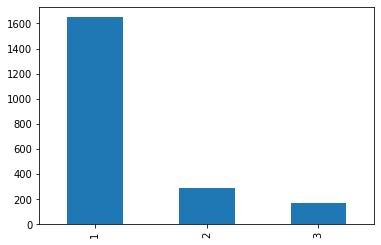

In [ ]:
#проверка сбалансированности классов
print(df['NSP'].value_counts(normalize=True))
df['NSP'].value_counts().plot(kind='bar', label='NSP')

In [ ]:
sns.pairplot(data=df, hue='NSP', corner=True)

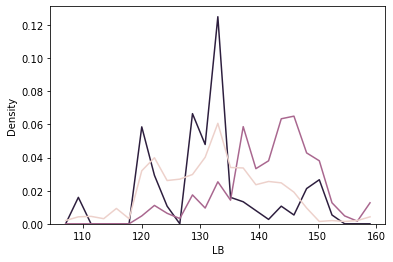

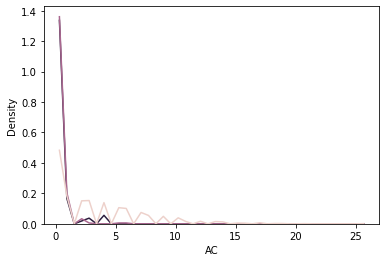

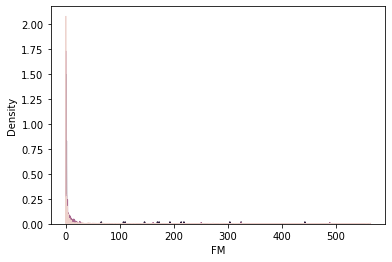

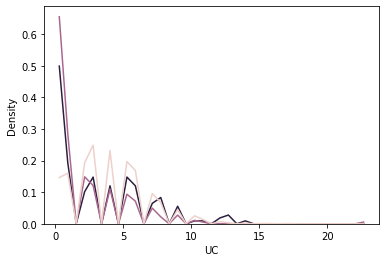

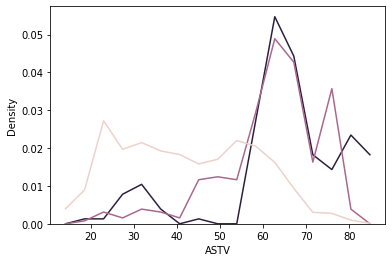

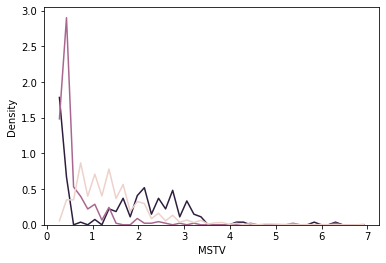

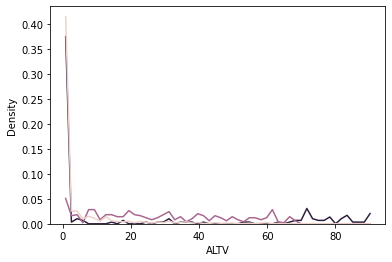

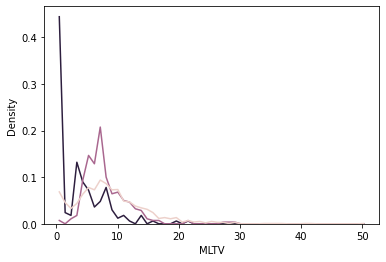

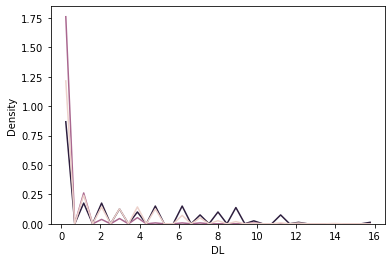

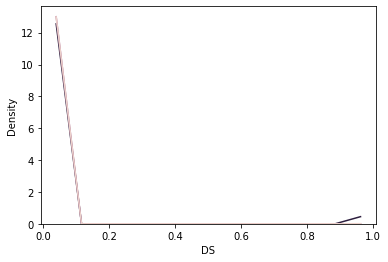

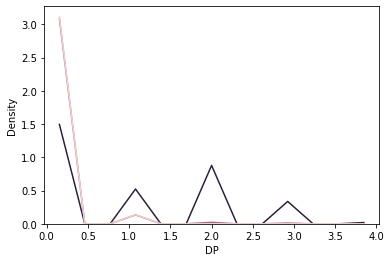

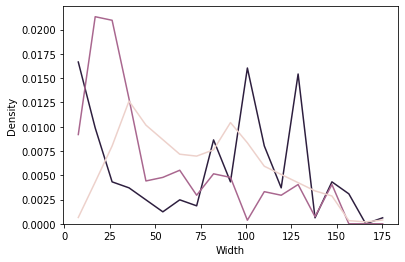

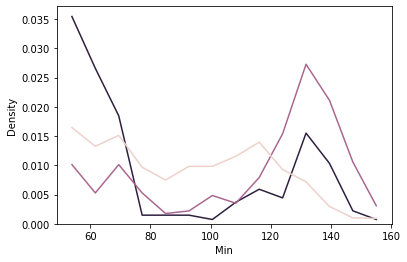

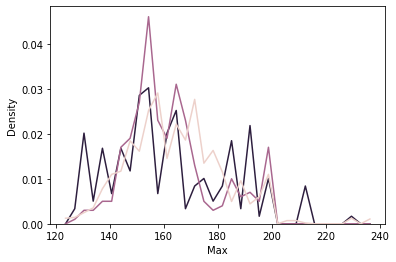

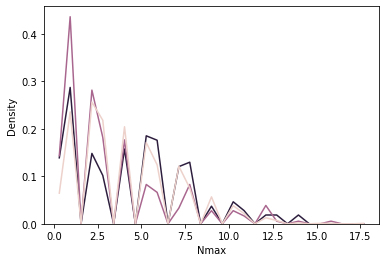

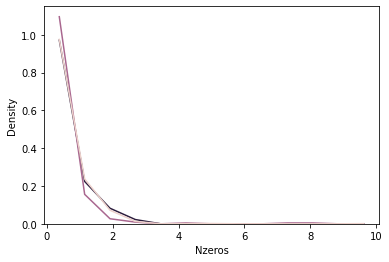

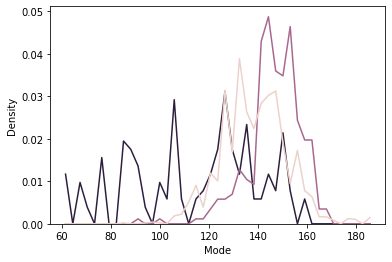

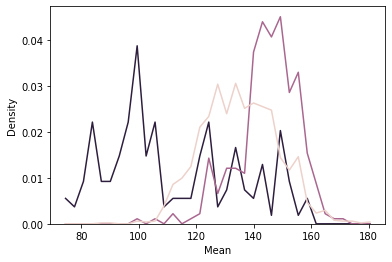

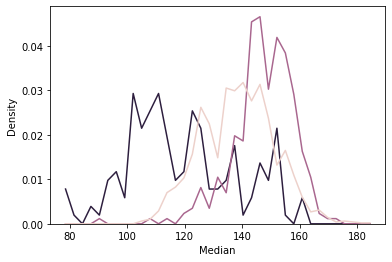

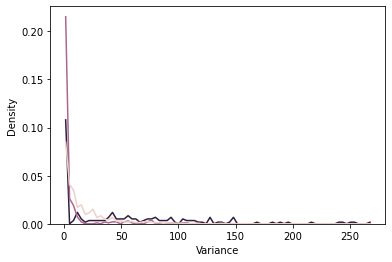

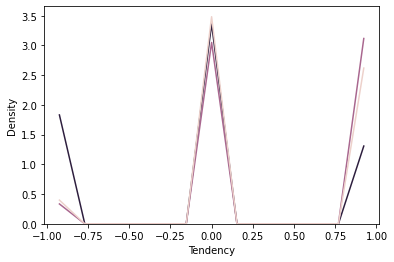

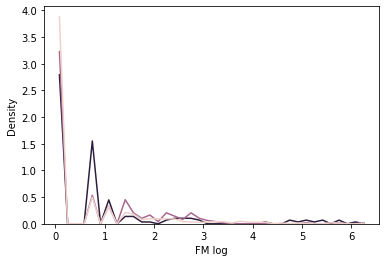

In [ ]:
for feat in list(df.drop(columns=['NSP', 'CLASS']).columns):
  sns.histplot(x = feat, data = df,  hue='NSP', kde=False, element="poly",
    stat="density", common_norm=False, fill=False, legend=False)
  # sns.distplot(df_clean[feat], hist_kws={"histtype": "step", "linewidth": 2,
  #                           "alpha": 1, "color": 'black'}, label='All', kde=False)
  plt.show()

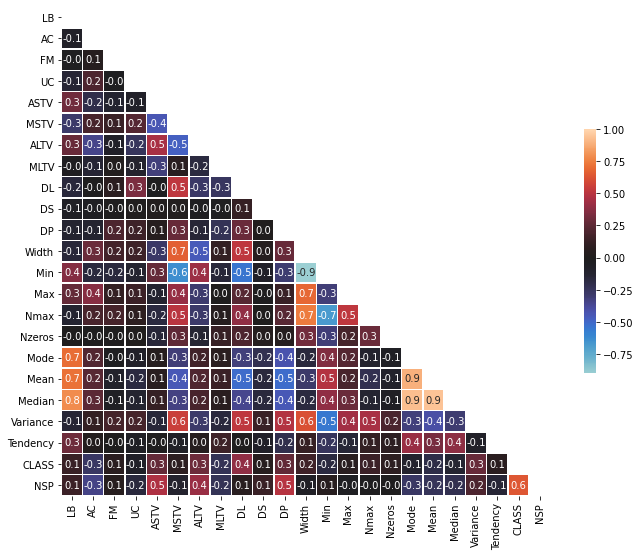

In [ ]:
features_all = list(df.columns)
corr = df[features_all].corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corr, mask=mask, vmax=1, center=0, annot=True, fmt='.1f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [4]:
df['FM log'] = np.log(df['FM']+1)
outliers_features = ['AC', 'MSTV', 'MLTV', 'ASTV', 'ALTV', 'DL', 'Max', 'Nmax', 'Median', 'FM log']
z_scores = zscore(df[outliers_features])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_clean_z = df[filtered_entries]
print('Z score')
print(df.shape[0], '-',  df.shape[0]-df_clean_z.shape[0], '=',df_clean_z.shape[0])
print('Deleted', (100*(df.shape[0]-df_clean_z.shape[0]))//df.shape[0], '%')

df_clean_q = df.copy()
Q1 = df[outliers_features].quantile(0.00)
Q3 = df[outliers_features].quantile(0.98)
for feat in outliers_features:
  df_clean_q = df_clean_q[(df_clean_q[feat]>=Q1[feat]) & (df_clean_q[feat]<=Q3[feat])]
print('IQR')
print(df.shape[0], '-',  df.shape[0]-df_clean_q.shape[0], '=',df_clean_q.shape[0])
print('Deleted', (100*(df.shape[0]-df_clean_q.shape[0]))//df.shape[0], '%')

Z score
2114 - 252 = 1862
Deleted 11 %
IQR
2114 - 326 = 1788
Deleted 15 %


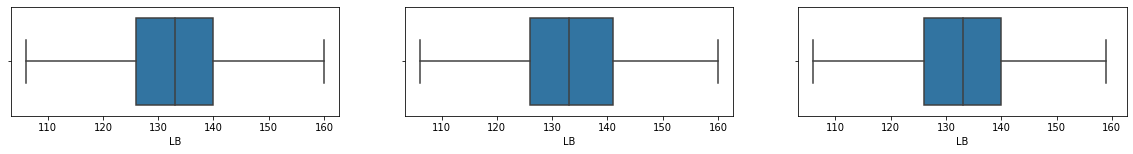

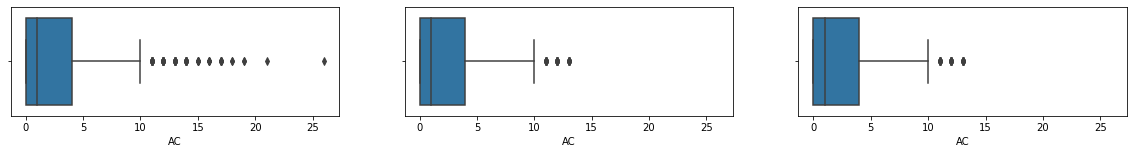

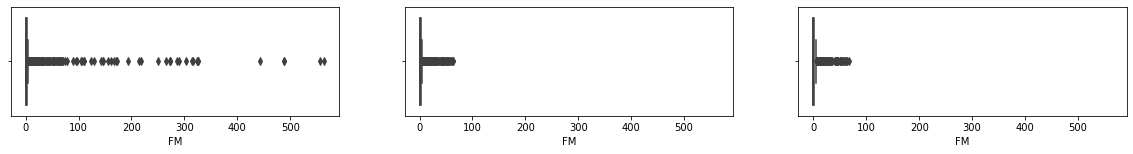

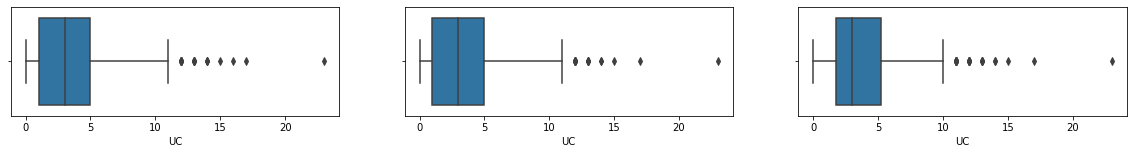

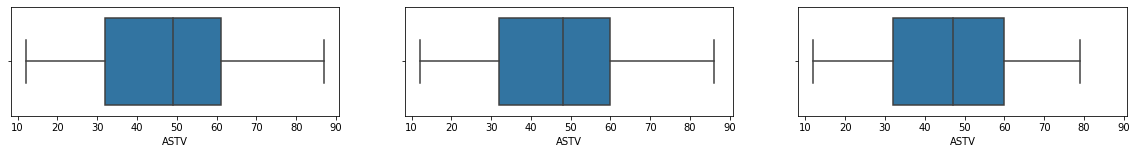

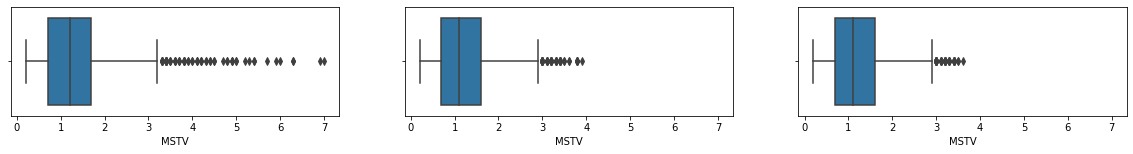

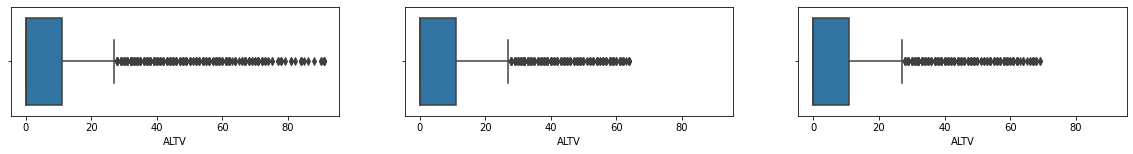

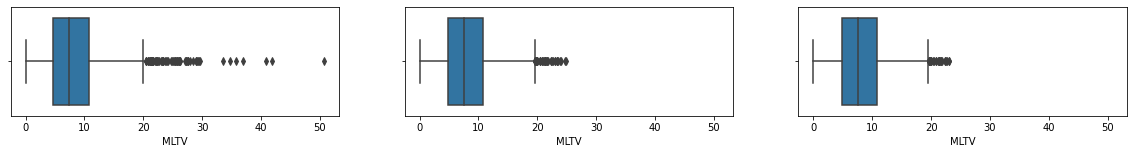

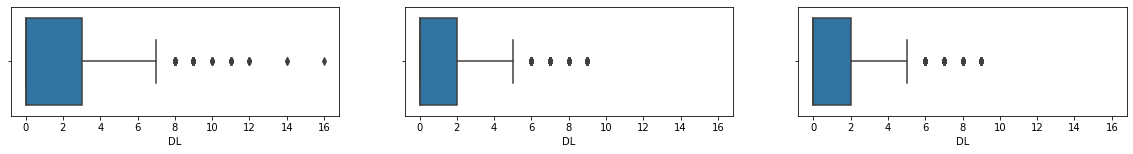

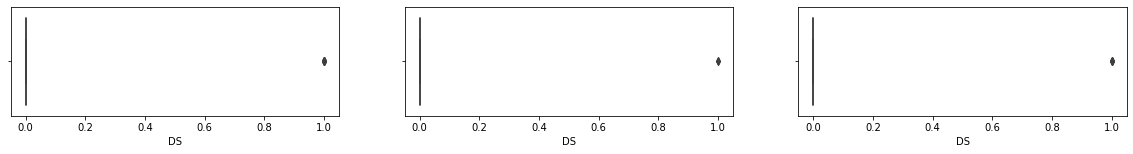

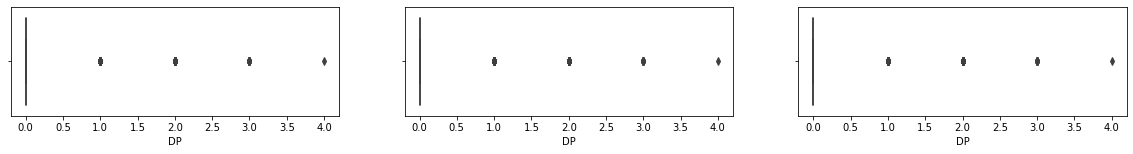

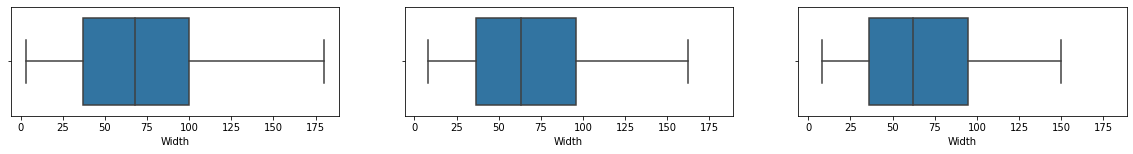

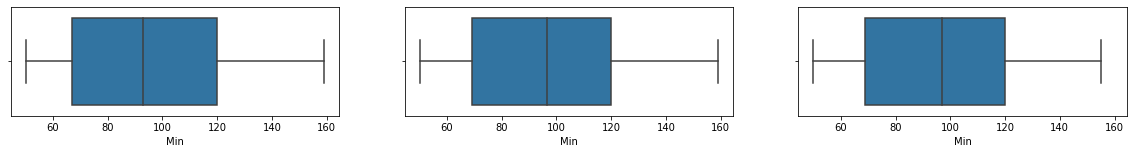

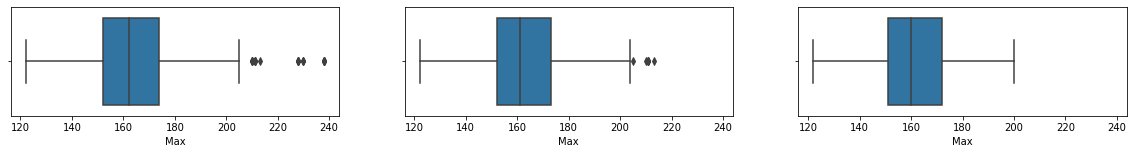

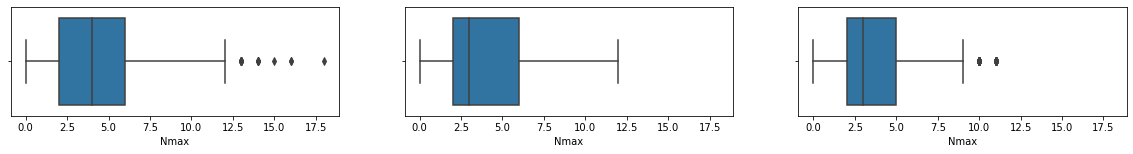

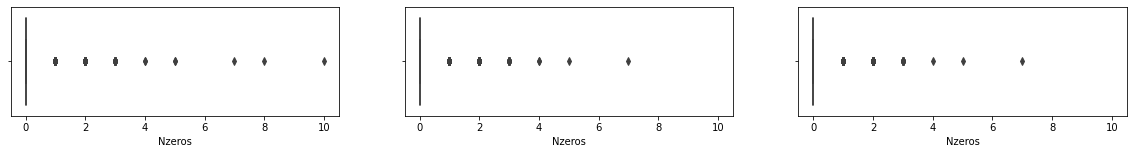

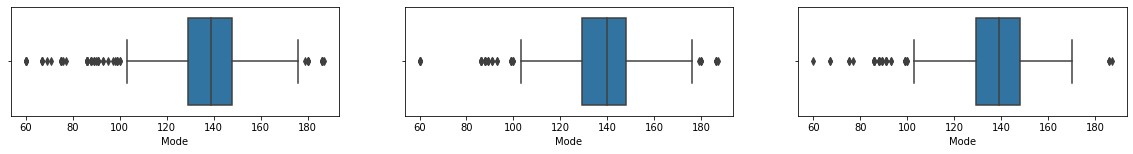

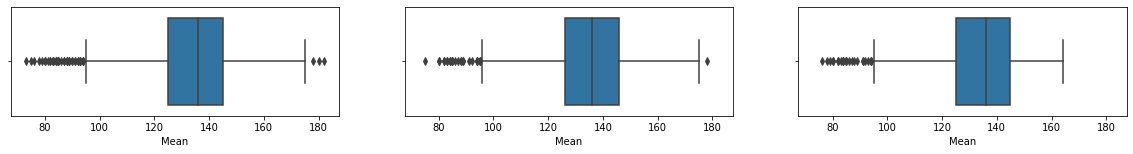

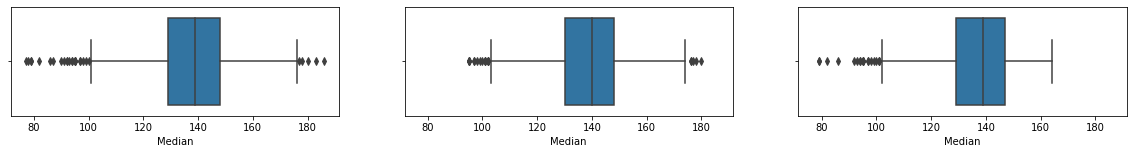

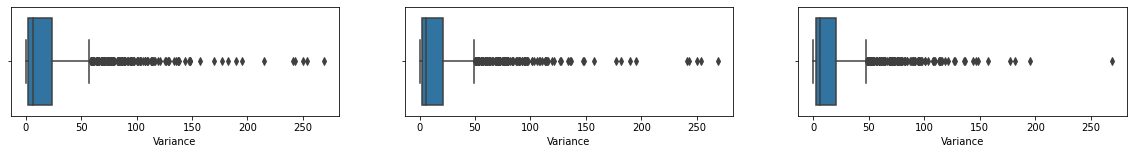

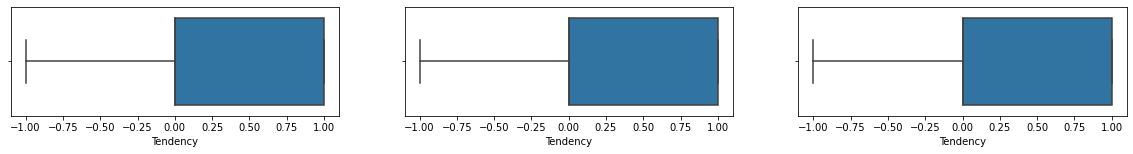

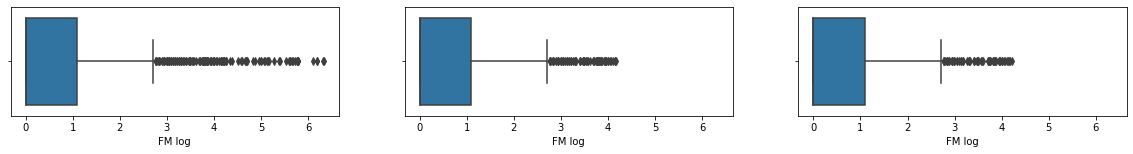

In [ ]:
for idx, feat in  enumerate(df.drop(columns=['NSP', 'CLASS']).columns):
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,2), sharex=True)
  sns.boxplot(x=feat, data=df, ax=axes[0], orient='h')
  sns.boxplot(x=feat, data=df_clean_z, ax=axes[1], orient='h')
  sns.boxplot(x=feat, data=df_clean_q, ax=axes[2], orient='h')
  plt.show()

In [5]:
df_dropped = df_clean_z.drop(columns=['Mode', 'Median'])

used_df = df_dropped
target = used_df['NSP']
train_df = used_df.drop(columns=['NSP', 'CLASS'])
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)

In [6]:
def rfc_clf(x_train, x_test, y_train, y_test):
  clf = RandomForestClassifier()
  cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                              cv=5, scoring=['accuracy', 'recall_weighted'])
  return 'RFC', '-', np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_recall_weighted'])

In [7]:
def knn_clf(x_train, x_test, y_train, y_test):
  knn_params = list(range(2, 10))
  all_predictions = []
  all_predictions_f = []
  for d in knn_params:
      clf = KNeighborsClassifier(n_neighbors=d)
      cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                                  cv=5, scoring=['accuracy', 'recall_weighted'])
      all_predictions.append(np.mean(cv_results['test_accuracy']))
      all_predictions_f.append(np.mean(cv_results['test_recall_weighted']))
      
  best_param = np.argmax(all_predictions)+2
  best_score = np.max(all_predictions)
  best_recall = all_predictions_f[np.argmax(all_predictions)]
  return 'KNN', best_param, best_score, best_recall

In [8]:
def svm_clf(x_train, x_test, y_train, y_test):
  kernels=['linear', 'poly', 'rbf', 'sigmoid']
  all_predictions = []
  all_predictions_f = []
  for k in kernels:
    clf = svm.SVC(kernel=k, C=10)
    cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                                cv=5, scoring=['accuracy', 'recall_weighted'])
    all_predictions.append(np.mean(cv_results['test_accuracy']))
    all_predictions_f.append(np.mean(cv_results['test_recall_weighted']))
  best_param = kernels[np.argmax(all_predictions)]
  best_score = np.max(all_predictions)
  best_recall = all_predictions_f[np.argmax(all_predictions)]
  return 'SVM', best_param, best_score, best_recall

In [15]:
def log_clf(x_train, x_test, y_train, y_test):
  clf = LogisticRegression(multi_class='ovr', max_iter=600)
  clf.fit(x_train, y_train)
  pred_test = clf.predict(x_test)
  best_param = np.NaN
  cv_results = cross_validate(clf, np.append(x_train, x_test,  axis=0), np.append(y_train, y_test, axis=0), 
                                cv=5, scoring=['accuracy', 'recall_weighted'])
  return 'Log', best_param, np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_recall_weighted'])

In [10]:
def mlp_clf(x_train, x_test, y_train, y_test):
  #solver{‘lbfgs’, ‘sgd’, ‘adam’}
  layer1_params = list(range(5, 30))
  layer2_params = list(range(0, 10))
  all_predictions = np.zeros((25, 10))
  all_predictions_f = np.zeros((25, 10))
  for i1, l1 in enumerate(layer1_params):
    for i2, l2 in enumerate(layer2_params):
      if not l2:
        layers = (l1)
      else:
        layers = (l1, l2)
      clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=layers, random_state=17, max_iter=1000, early_stopping=True)
      clf.fit(x_train, y_train)
      pred_test = clf.predict(x_test)
      all_predictions[i1,i2] = accuracy_score(y_test, pred_test)
      all_predictions_f[i1,i2] = recall_score(y_test, pred_test,average='weighted')
  param = np.unravel_index(np.argmax(all_predictions, axis=None), all_predictions.shape)  
  best_param = (param[0]+5, param[1])
  best_score = np.max(all_predictions)
  best_recall = np.max(all_predictions_f)
  return 'MLP', best_param, best_score, best_recall

In [16]:
classifiers = [rfc_clf, svm_clf, knn_clf, log_clf, mlp_clf]
stand_df = scaler.fit_transform(train_df)
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
for clf in classifiers:
  start = time.time()
  res = clf(x_tr, x_ts, y_tr, y_ts)
  end = time.time()
  print(res[0], res[1], round(res[2], 3),  round(res[3], 2), 'time:', round(end-start, 1))

RFC - 0.946 0.95 time: 1.5
SVM rbf 0.929 0.93 time: 1.3
KNN 7 0.911 0.91 time: 1.4
Log nan 0.905 0.91 time: 0.5
MLP (12, 8) 0.873 0.87 time: 38.1


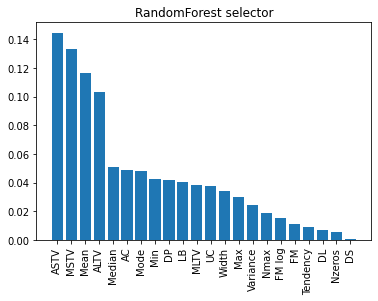

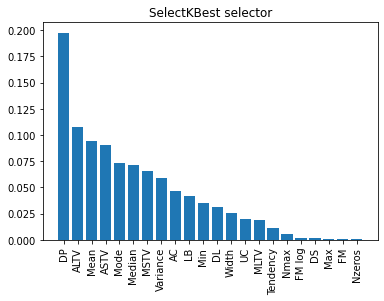

In [ ]:
used_df = df_clean_z
columns_all = list(used_df.drop(columns=['NSP', 'CLASS']).columns)
forest_feature_selector = RandomForestClassifier(max_depth = 10, n_estimators=100, n_jobs=-1, random_state=17)
forest_feature_selector.fit(used_df[columns_all], used_df['NSP'])
importance = forest_feature_selector.feature_importances_
columns_rfc = [x for _, x in sorted(zip(importance, columns_all), key=lambda pair: pair[0], reverse=True)]
importance_sorted =  sorted(importance, reverse=True)
plt.bar(columns_rfc, importance_sorted)
plt.title('RandomForest selector')
plt.xticks(rotation=90)
plt.show()

kb_feature_selector = SelectKBest(f_classif, 'all')
kb_feature_selector.fit_transform(used_df[columns_all], used_df['NSP'])
scores = -np.log10(kb_feature_selector.pvalues_)
scores /= np.nansum(scores)
scores_sorted = [scores[columns_all.index(c)] for c in columns_sorted]
columns_skb = [x for _, x in sorted(zip(scores, columns_all), key=lambda pair: pair[0], reverse=True)]
plt.bar(columns_skb, sorted(scores, reverse=True))
plt.title('SelectKBest selector')
plt.xticks(rotation=90)
plt.show()

# fig = plt.subplots(figsize =(12, 8))
# barWidth = 0.25 
# br1 = np.arange(len(columns_all)) 
# br2 = [x + barWidth for x in br1] 
# plt.bar(br1, importance_sorted, color ='r', width = barWidth, edgecolor ='grey', label ='RFC') 
# plt.bar(br2, scores_sorted, color ='g', width = barWidth, edgecolor ='grey', label ='SKB') 
# plt.xticks([r + barWidth for r in range(len(columns_all))], columns_sorted)   
# plt.legend()
# plt.xticks(rotation=90)
# plt.show() 

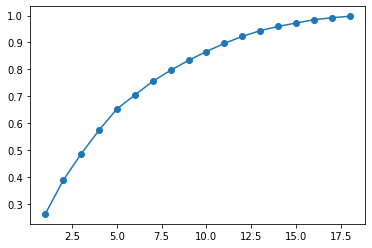

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=18)
pca.fit(stand_df)
plt.plot(np.arange(1, 19), np.cumsum(pca.explained_variance_ratio_))
plt.scatter(np.arange(1, 19), np.cumsum(pca.explained_variance_ratio_))

In [ ]:
df_dropped = df_clean_z.drop(columns=['Mode', 'Median'])
columns_rfc.remove('Mode')
columns_rfc.remove('Median')
columns_skb.remove('Mode')
columns_skb.remove('Median')

used_df = df_dropped
target = used_df['NSP']
train_df = used_df.drop(columns=['NSP', 'CLASS'])
scaler = StandardScaler()
stand_df = scaler.fit_transform(train_df)

('RFC', '-', 0.921594741849001, 0.921594741849001)
11
('RFC', '-', 0.9489838277263687, 0.9489838277263687)
16
('RFC', '-', 0.9479042347718296, 0.9479042347718296)
14


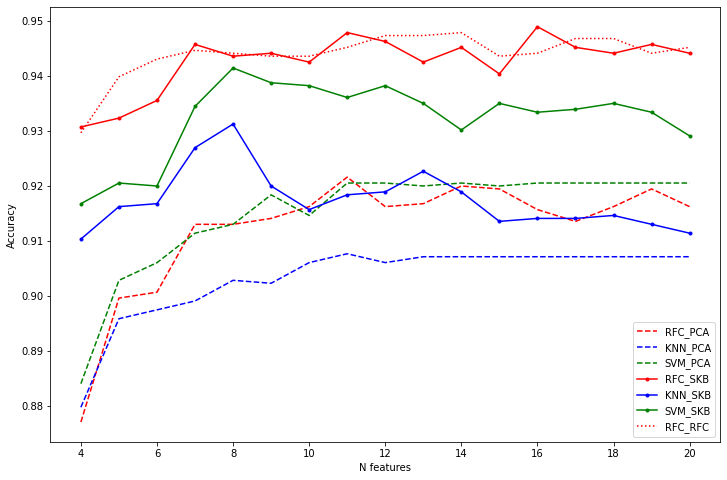

CPU times: user 18min 14s, sys: 200 ms, total: 18min 14s
Wall time: 18min 14s


In [ ]:
#не запускать без особой надобности
%%time
fig = plt.subplots(figsize =(12, 8)) 
n_features = np.arange(4, len(train_df.columns)+1)
line = ['--', '.-', ':']
prefix = ['_PCA', '_SKB', '_RFC']
for sel in range(3): 
  rfc_res = []
  svm_res = []
  knn_res = []
  mlp_res = []
  log_res = []
  max_score = 0
  for n_feat in n_features:
    if sel:
      if sel==1:
        train_df_kbest = train_df[columns_skb[:n_feat]]
      else:
        train_df_kbest = train_df[columns_rfc[:n_feat]]
      stand_df = scaler.fit_transform(train_df_kbest)
      x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)
    else:
      trans_df = PCA(n_feat).fit_transform(train_df)
      x_tr, x_ts, y_tr, y_ts = train_test_split(trans_df, target, test_size=.3, random_state=17)
    if sel==2:
      res = rfc_clf(x_tr, x_ts, y_tr, y_ts)
      rfc_res.append(res[2])
      if res[2]>max_score:
        res_max = res
        max_score = res[2]
        n_feat_max = n_feat     
    else:
      for clf, clf_res in zip([rfc_clf, svm_clf, knn_clf], [rfc_res, svm_res, knn_res]):
        res = clf(x_tr, x_ts, y_tr, y_ts)
        clf_res.append(res[2])
        if res[2]>max_score:
          res_max = res
          max_score = res[2]
          n_feat_max = n_feat
  print(res_max)
  print(n_feat_max)

  if sel==2:
    plt.plot(n_features, rfc_res, line[sel], color='r', label='RFC'+prefix[sel])
  else:
    plt.plot(n_features, rfc_res, line[sel], color='r', label='RFC'+prefix[sel])
    plt.plot(n_features, knn_res, line[sel], color='b', label='KNN'+prefix[sel])
    plt.plot(n_features, svm_res, line[sel], color='g', label='SVM'+prefix[sel])
    # plt.plot(n_features, mlp_res, line[sel], color='cyan', label='MLP'+prefix[sel])
plt.xlabel('N features')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.8, 1.0)
plt.grid()
plt.xticks()
plt.show()

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
output.clear()

stand_df = scaler.fit_transform(train_df)
x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.3, random_state=17)

model = RandomForestClassifier().fit(x_tr, y_tr)
perm = PermutationImportance(model).fit(x_ts, y_ts)

importance = perm.feature_importances_
columns_perm = [x for _, x in sorted(zip(importance, train_df.columns), key=lambda pair: pair[0], reverse=True)]

eli5.show_weights(perm, feature_names=train_df.columns.tolist())

Weight,Feature
0.0748 ± 0.0094,ASTV
0.0515 ± 0.0062,MSTV
0.0358 ± 0.0039,Mean
0.0279 ± 0.0203,AC
0.0215 ± 0.0064,ALTV
0.0140 ± 0.0073,UC
0.0111 ± 0.0057,LB
0.0075 ± 0.0035,FM
0.0057 ± 0.0057,Max
0.0054 ± 0.0064,Variance


In [ ]:
eli5.show_weights(model, feature_names=train_df.columns.tolist())

Weight,Feature
0.1436 ± 0.2145,AC
0.1363 ± 0.1575,FM
0.1354 ± 0.1473,LB
0.0911 ± 0.1483,UC
0.0551 ± 0.0895,ASTV
0.0539 ± 0.0698,MLTV
0.0537 ± 0.1151,ALTV
0.0504 ± 0.0706,DL
0.0499 ± 0.0778,MSTV
0.0472 ± 0.0765,DS


_PI ('RFC', '-', 0.9484548415924356, 0.9484548415924356)
_PI 10
_RFC ('RFC', '-', 0.9463129522326963, 0.9463129522326963)
_RFC 18


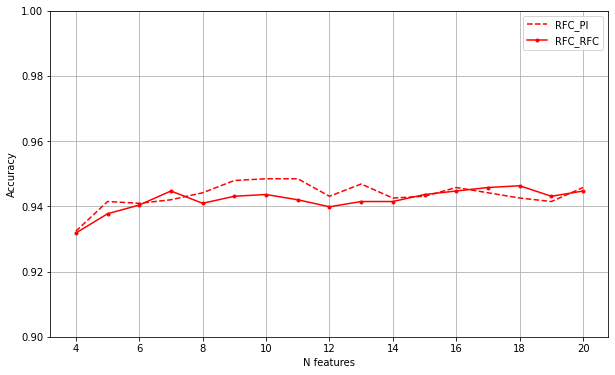

CPU times: user 47.2 s, sys: 83.2 ms, total: 47.3 s
Wall time: 47.4 s


In [ ]:
%%time
fig = plt.subplots(figsize =(9, 4)) 
n_features = np.arange(4, len(train_df.columns)+1)
line = ['--', '.-']
prefix = ['_PI', '_RFC'] 
for sel in [0, 1]:  
  rfc_res = []
  max_score = 0
  for n_feat in n_features:
    if sel==0:
      train_df_kbest = train_df[columns_perm[:n_feat]]
    else:
      train_df_kbest = train_df[columns_rfc[:n_feat]]
    stand_df = scaler.fit_transform(train_df_kbest)
    x_tr, x_ts, y_tr, y_ts = train_test_split(stand_df, target, test_size=.2, random_state=18)

    res = rfc_clf(x_tr, x_ts, y_tr, y_ts)
    rfc_res.append(res[2])
    if res[2]>max_score:
      res_max = res
      max_score = res[2]
      n_feat_max = n_feat 
  print(prefix[sel], res_max)
  print(prefix[sel], n_feat_max)
  plt.plot(n_features, rfc_res, line[sel], color='r', label='RFC'+prefix[sel])

plt.xlabel('N features')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks()
plt.ylim(0.9, 1.0)
plt.grid()
plt.show()

In [ ]:
used_df = [df, df_clean_z, df_clean_q]
print_used_df = ['With outliers', 'Cleaned Z', 'Cleaned Q']
parameters = {'n_estimators' : [50, 100, 150], 'class_weight' : [None, 'balanced', {1: 0.1, 2: 0.5, 3: 0.5}, {1: 0.1, 2: 0.1, 3: 0.1}]}
feats = columns_perm[:10]
rfc = RandomForestClassifier()
gscv1 = GridSearchCV(rfc, parameters, scoring = 'recall_weighted', cv=5)
gscv2 = GridSearchCV(rfc, parameters, scoring = 'accuracy', cv=5)
print('Used features: ', feats, '\n')
for idx, ud in enumerate(used_df):
  gscv1.fit(StandardScaler().fit_transform(ud[feats]), ud['NSP'])
  gscv2.fit(StandardScaler().fit_transform(ud[feats]), ud['NSP'])
  print(print_used_df[idx])
  print('Accuracy: ', gscv2.best_score_)
  print(gscv2.best_params_)
  print('Recall: ', gscv1.best_score_)
  print(gscv1.best_params_)
  print()

Used features:  ['ASTV', 'MSTV', 'Mean', 'AC', 'ALTV', 'UC', 'LB', 'FM', 'Max', 'Variance'] 

With outliers
Accuracy:  0.8599105912406305
{'class_weight': 'balanced', 'n_estimators': 50}
Recall:  0.8584854290612081
{'class_weight': 'balanced', 'n_estimators': 150}

Cleaned Z
Accuracy:  0.8748407276081756
{'class_weight': None, 'n_estimators': 50}
Recall:  0.8646501772896308
{'class_weight': 'balanced', 'n_estimators': 50}

Cleaned Q
Accuracy:  0.8808099776223338
{'class_weight': 'balanced', 'n_estimators': 100}
Recall:  0.8808021532635399
{'class_weight': {1: 0.1, 2: 0.1, 3: 0.1}, 'n_estimators': 100}



In [ ]:
rfc = RandomForestClassifier(n_estimators=50, class_weight={1: 0.1, 2: 0.1, 3: 0.1})
stand_df = scaler.fit_transform(df_clean_z[columns_sorted[:6]])
x, y = shuffle(stand_df, df_clean_z['NSP'])
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=.3, random_state=14)
rfc.fit(x_tr, y_tr)
res = rfc.predict(x_ts)
cv_results = cross_validate(rfc, x, y, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted'])
print("Score cv: ", np.mean(cv_results['test_accuracy']))
print("Score: ", accuracy_score(y_ts, res))
print("\nPrecision cv: ", np.mean(cv_results['test_precision_weighted']))
print("Precision: ", precision_score(y_ts, res, average=None))
print("\nRecall cv: ", np.mean(cv_results['test_recall_weighted']))
print("Recall: ", recall_score(y_ts, res, average=None))
print("\nROC AUC cv: ", np.mean(cv_results['test_roc_auc_ovr_weighted']))
print("ROC AUC: ", roc_auc_score(y_ts, rfc.predict_proba(x_ts), average='weighted', multi_class='ovr'))
print("\nConfusion matrix: \n", confusion_matrix(y_ts, res))

Score cv:  0.9371645190117904
Score:  0.9427549194991055

Precision cv:  0.9360947101942874
Precision:  [0.94493392 0.91025641 1.        ]

Recall cv:  0.9371645190117904
Recall:  [0.98847926 0.80681818 0.72972973]

ROC AUC cv:  0.9719873563716437
ROC AUC:  0.9796407698144554

Confusion matrix: 
 [[429   5   0]
 [ 17  71   0]
 [  8   2  27]]


In [ ]:
from google.appengine.api import users
import webapp2
import os
import urllib
from google.appengine.ext.webapp import blobstore_handlers
from google.appengine.ext import blobstore

class Upload(blobstore_handlers.BlobstoreUploadHandler):
  def post(self):
    upload_files = self.get_uploads('myUploadedFile')
    blob_info = upload_files[0]
    self.response.write('<html><body>')
    self.response.write('Uploaded file: ' + str(blob_info.filename))
    self.response.write('</body></html>')

class MainHandler(webapp2.RequestHandler):
  def get(self):
    user = users.get_current_user() 
    upload_url = blobstore.create_upload_url('/upload')
    if user:
      self.response.write('<form action="%s" method="POST" enctype="multipart/form-data">' % upload_url)
      self.response.write("""Upload File: <input type="file" name="myUploadedFile"><br />""")
      self.response.write("""<input type="submit" name="submit" value="Submit"> </form>""")
    else:
        self.redirect(users.create_login_url(self.request.uri))

app = webapp2.WSGIApplication([('/', MainHandler), ('/upload', Upload)], debug=True)


In [ ]:
#!/usr/bin/env python
#
# Copyright 2007 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
import webapp2
from google.appengine.api import users

class MainHandler(webapp2.RequestHandler):
  def get(self):
    user = users.get_current_user()
    if user: 
      self.response.write(user.nickname())
    else:
      self.redirect(users.create_login_url(self.request.uri))

app = webapp2.WSGIApplication([('/', MainHandler)], debug=True)
